In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
hidden_dim = 30
n_epochs = 300
time_steps = 30
look_interval = 60
batch_size = 130
# pred_timesteps = 5
activation = None
loss = 'logcosh'

#log(cosh(x)) is approximately equal to (x ** 2) / 2 for small x and to abs(x) - log(2) for large x. 
#This means that 'logcosh' works mostly like the mean squared error, 
#but will not be so strongly affected by the occasional wildly incorrect prediction.

In [3]:
def create_dataset(data, time_steps = time_steps):  
    # Scaling data ?
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    global data_dim
    data_dim = data.shape[1]
    s = data[0 : time_steps].squeeze()
   
    for i in range(1, len(data) - time_steps):
        t = data[i: i + time_steps].squeeze()
        s = np.vstack((s, t))
   
    return s, scaler

In [4]:
def reshape_dataset(x, y):
    if x is not None:
        if len(x.shape) == 2:
            x = x.reshape(x.shape[0], x.shape[1], 1)
    if len(y.shape) == 1:
        y = y.reshape(y.shape[0],1)
    return x, y 

In [5]:
def load_data(ticker):
    v_pct = pd.DataFrame()
    for date in train_date_list:
        v = pd.read_csv('{}_{}.csv'.format(ticker, date), header = None)
        v_pct = pd.concat([v_pct, v], axis = 0) 
        
#     bid = pd.DataFrame()
#     for date in train_date_list:   
#         b = pd.read_csv('{}_{}_bid.csv'.format(ticker, date), header = None)
#         bid = pd.concat([bid, b], axis = 0)
    
#     ask = pd.DataFrame()
#     for date in train_date_list:   
#         a = pd.read_csv('{}_{}_ask.csv'.format(ticker, date), header = None)
#         ask = pd.concat([ask, a], axis = 0)
    
#     mid = pd.DataFrame()
#     for date in train_date_list:   
#         m = pd.read_csv('{}_{}_mid.csv'.format(ticker, date), header = None)
#         mid = pd.concat([mid, m], axis = 0)
 
#     data = pd.concat([v_pct, bid, ask, mid], axis =1)
    return v_pct

In [6]:
class LSTM_Model():
    def __init__(self):
        self.model = Sequential()
        return 
    
    def build(self,  time_steps = time_steps-1, data_dim = 1, output_dim = 1):
        # expected input batch shape: (batch_size, timesteps, data_dim)
        # the sample of index i in batch k is the follow-up for the sample i in batch k-1.
        self.model.add(LSTM(hidden_dim, return_sequences=True, input_shape=(time_steps, data_dim)))
        self.model.add(LSTM(hidden_dim, return_sequences=True))
        self.model.add(LSTM(hidden_dim))
        self.model.add(Dense(output_dim, activation = activation))

        self.model.compile(loss = loss, optimizer='rmsprop', metrics=['accuracy']) #?
        return self.model

    def train_test(self, seqs, plot = True):
        x = seqs[:, : -1]
        y = seqs[:, -1]
        
        size = len(seqs)
        x = x[: batch_size * (size // batch_size)]
        y = y[: batch_size * (size // batch_size)]
        
        x, y = reshape_dataset(x, y)

        x_train, x_validation, y_train, y_validation= train_test_split(x, y, test_size = 0.02, shuffle = True)
        print('train', x_train.shape, y_train.shape)
        print('insample test', x_validation.shape, y_validation.shape)
       
        history = self.model.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs,
                                 validation_split = 0.1, verbose = 0)
        
        self.y_pred = self.predict(x_validation)
        self.y_validation_true = y_validation
        
        if plot == True:
            self.train_plot = self.view_accuracy(self.predict(x_train), y_train, 'Train')
            self.validation_plot = self.view_accuracy(self.predict(x_validation), y_validation, 'Validation')
        return history

    def predict(self, x_validation):
        pred = self.model.predict(x_validation)
        return pred
    
    def view_accuracy(self, y_pred = None, y_true = None, plot_name = 'Test'):
        if y_pred is None:
            y_pred = self.y_pred
            y_true = self.y_validation_true
            
        plt.style.use('seaborn')
        plt.figure(figsize = (10,6),)
        plt.grid(True)
        plt.plot(y_pred, color = 'lightcoral')
        plt.plot(y_true, color = 'cornflowerblue', linewidth = 1)
        plt.title('{}_{}'.format(ticker, plot_name))
        plt.legend(['predict', 'true'])
        if plot_name == 'Test':
            plt.savefig('{}_{}_{}_{}_{}.png'.format(ticker, plot_name, str(time_steps), str(batch_size), test_date))
        else:
            plt.savefig('{}_{}_{}_{}.png'.format(ticker, plot_name, str(time_steps), str(batch_size)))


In [7]:
def try_model():
#     data = pd.DataFrame()
#     for date_name in date_list:
#         d = pd.read_csv('{}_{}.csv'.format(ticker, date_name), header = None)
#         data = pd.concat([data, d], axis = 0) 
#     seqs, scaler = create_dataset(data)
#     print(seqs[0])
    
    l = LSTM_Model()
    l.build()
    l.train_test(seqs)
    return l.y_pred

In [8]:
def loss_plot(history, plot_name = 'Loss'): # type(history) is dict
    loss = np.asarray(history['loss'])
    val_loss = np.asarray(history['val_loss'])
    
    plt.style.use('seaborn')
    plt.figure(figsize = (10,6))
    plt.grid(True)
    plt.plot(loss, color = 'darkgrey')
    plt.plot(val_loss, color = 'tan')
    plt.legend(['loss', 'val_loss'])
    plt.savefig('{}_{}_{}_{}_{}.png'.format(ticker, plot_name, str(n_epochs), str(time_steps), str(batch_size)))


In [19]:
def new_data_test(ticker, plot = True):
    # Load train data
    a = load_data(ticker)
    seqs, scaler = create_dataset(a)
    
    # Build model, in-sample train test
    l = LSTM_Model()
    l.build()
    train_history = l.train_test(seqs, plot)  
    if plot == True:
        loss_plot(train_history.history)
        
    #  Out-of-sample test, 9:30 am - 10:00 am
    global test_date
    for test_date in test_date_list:
        # create test dateset
        v_pct = pd.read_csv('{}_{}.csv'.format(ticker, test_date))
        v_pct = v_pct.iloc[:look_interval+time_steps, :]
        v_pct, scaler = create_dataset(v_pct)
        x_test = v_pct[:, : -1]
        y_test = v_pct[:, -1]

        x_test, y_test = reshape_dataset(x_test, y_test)
    
        # use precious trained model to test
        y_test_pred = l.predict(x_test)
        if plot == True:
            l.view_accuracy(y_test_pred, y_test, 'Test')
       
        
        pred_30 = y_test_pred[:30]
      
        y_out =  pd.DataFrame((pred_30 / pred_30.sum()))
        y_out.to_csv('{}_{}_pred.csv'.format(ticker, test_date), index = False)
    return l.model


train (3312, 29, 1) (3312, 1)
insample test (68, 29, 1) (68, 1)


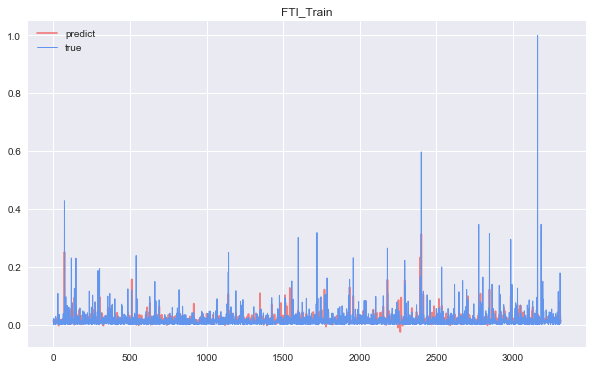

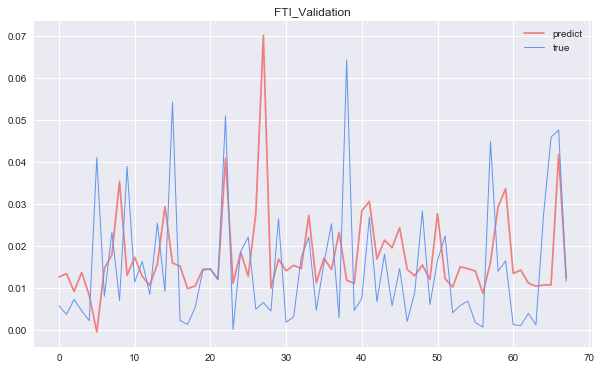

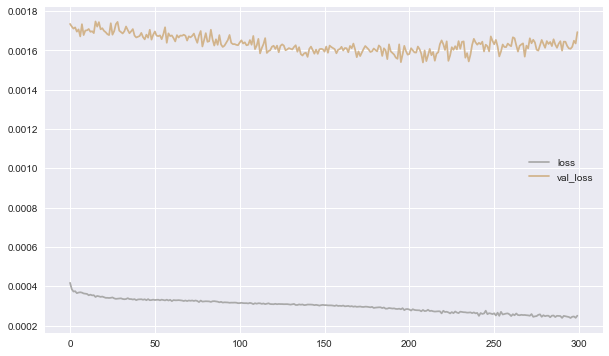

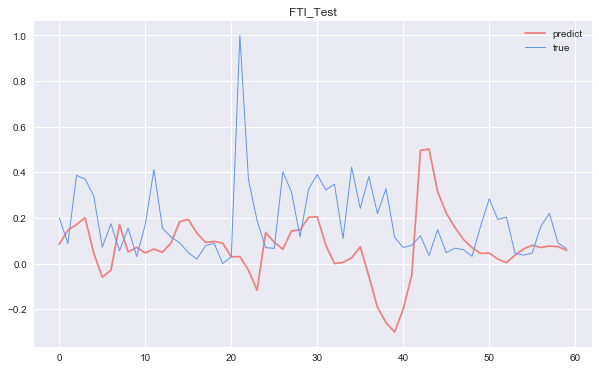

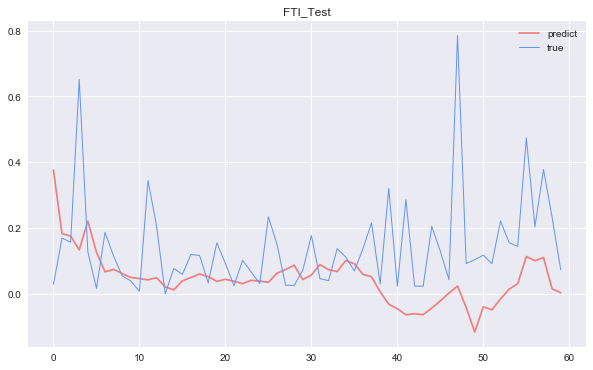

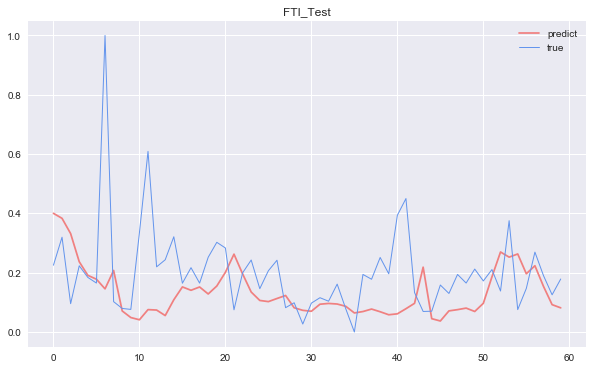

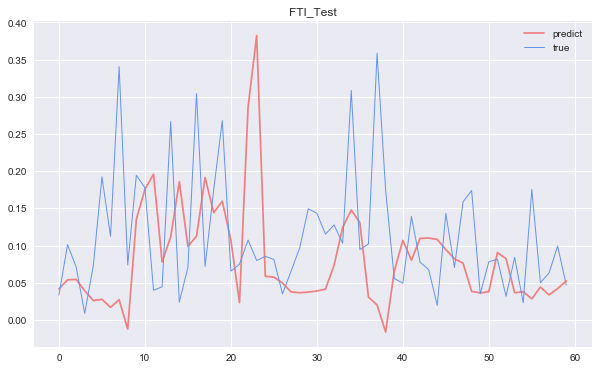

In [29]:
# FTI
hidden_dim = 30
n_epochs = 300
time_steps = 30
look_interval = 60
batch_size = 130
# pred_timesteps = 5
activation = None
loss = 'logcosh'

ticker = 'FTI'
model = new_data_test(ticker, plot = True) 

train (3057, 29, 1) (3057, 1)
insample test (63, 29, 1) (63, 1)


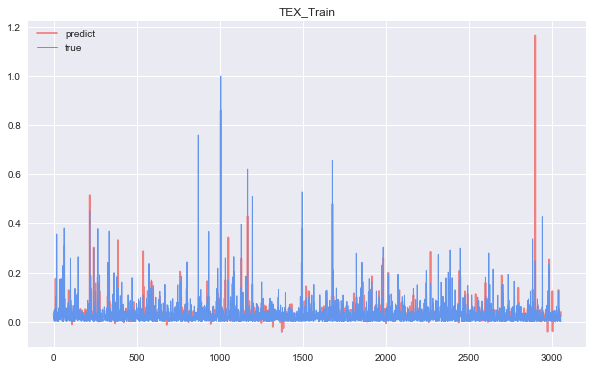

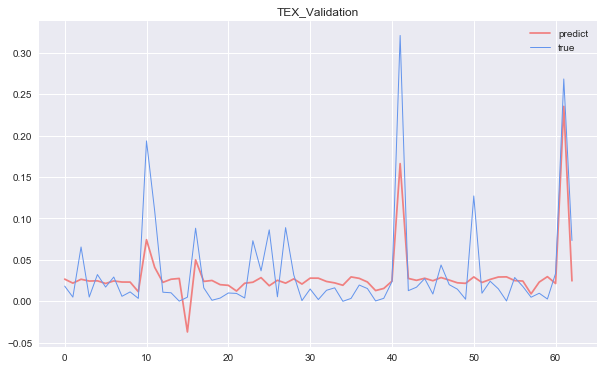

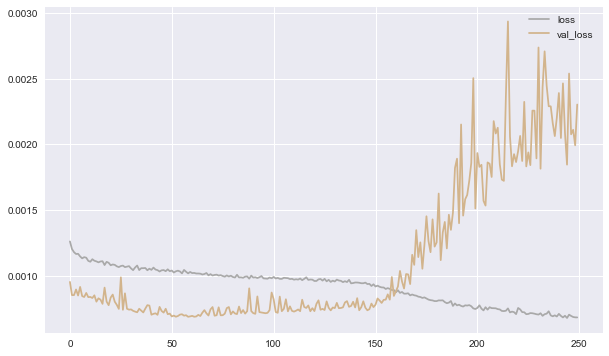

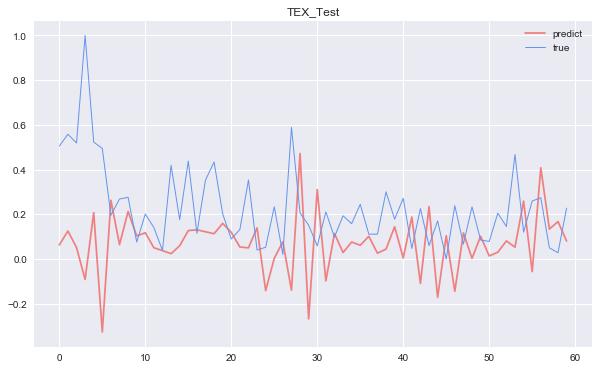

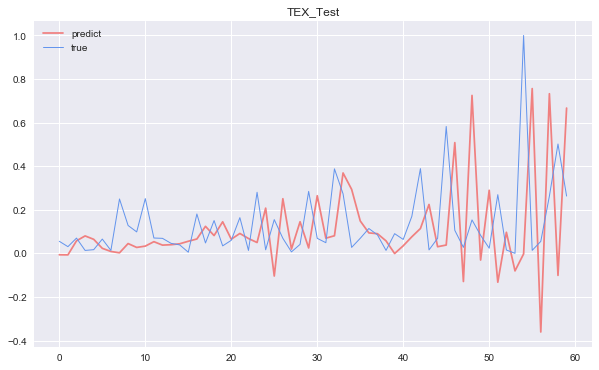

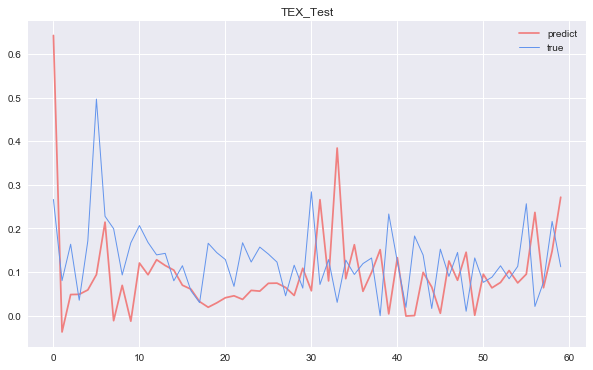

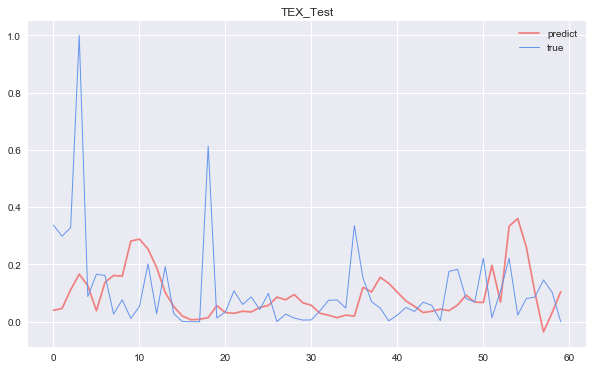

In [28]:
# TEX
hidden_dim = 30
n_epochs = 250
time_steps = 30
batch_size = 260
look_interval = 60
activation = None
loss = 'logcosh'

ticker = 'TEX'
model = new_data_test(ticker, plot = True) 

train (3312, 29, 1) (3312, 1)
insample test (68, 29, 1) (68, 1)


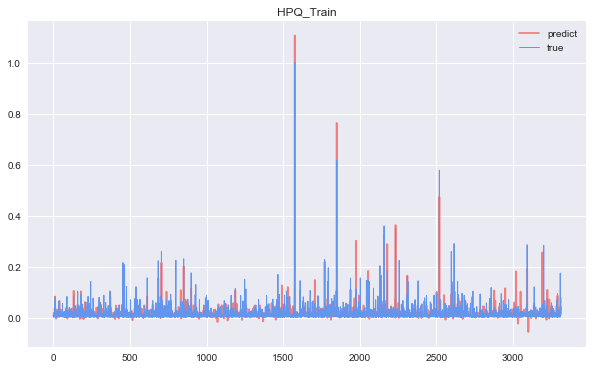

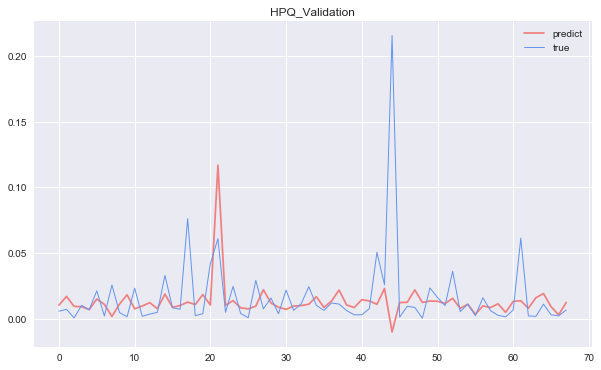

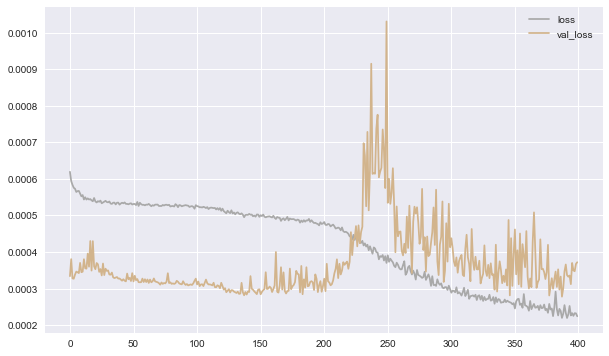

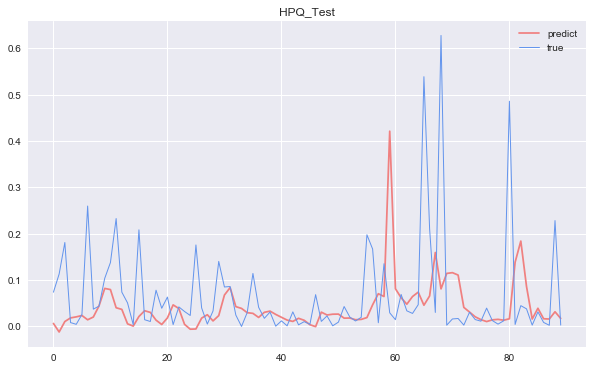

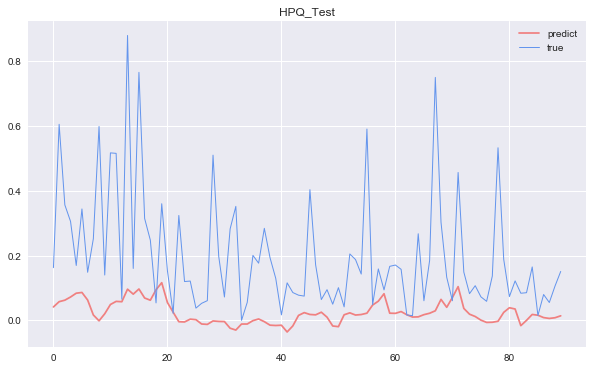

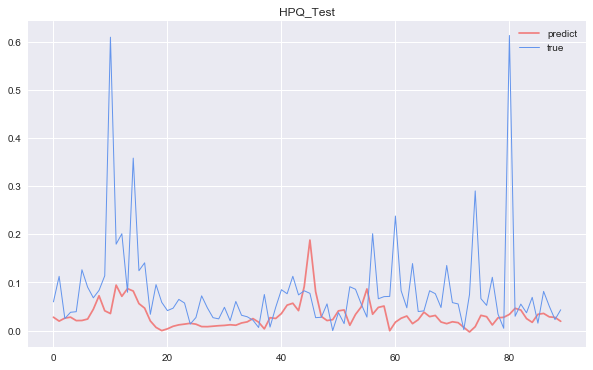

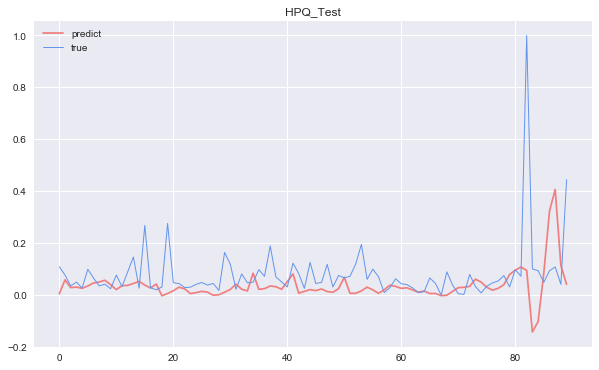

In [27]:
# HPQ
hidden_dim = 30
n_epochs = 400
time_steps = 60
batch_size = 130
look_interval = 60
activation = None
loss = 'logcosh'

ticker = 'HPQ'
model = new_data_test(ticker, plot = True) 

train (2930, 29, 1) (2930, 1)
insample test (60, 29, 1) (60, 1)


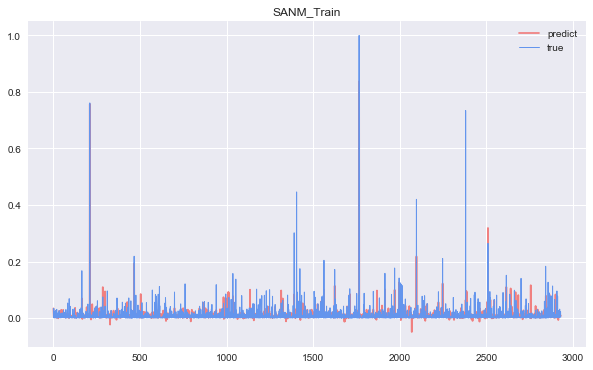

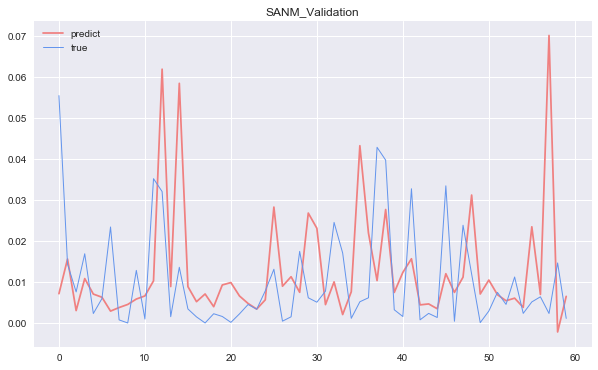

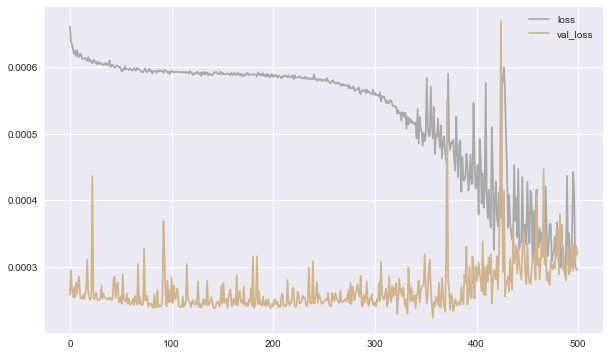

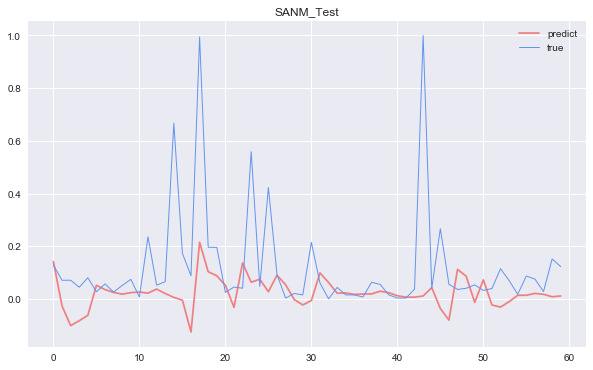

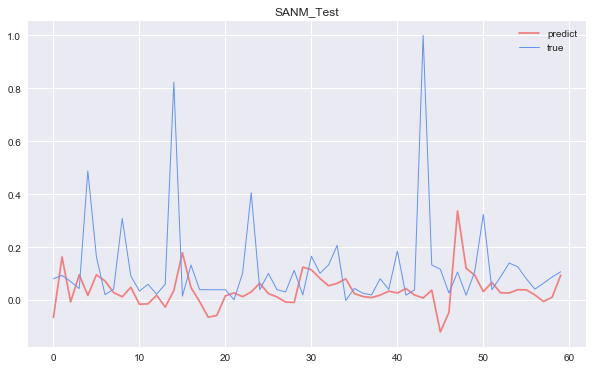

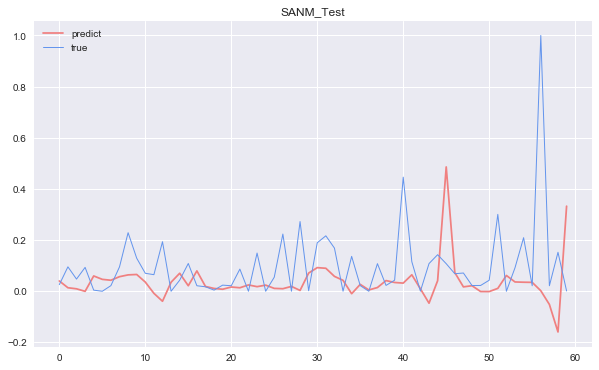

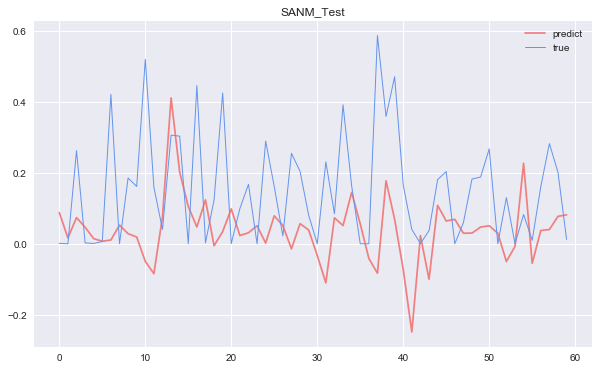

In [26]:
# SANM
hidden_dim = 30
n_epochs = 500
time_steps = 30
batch_size = 130
look_interval = 60
activation = None
loss = 'logcosh'

ticker = 'SANM'
model = new_data_test(ticker, plot = True) 

train (3567, 29, 1) (3567, 1)
insample test (73, 29, 1) (73, 1)


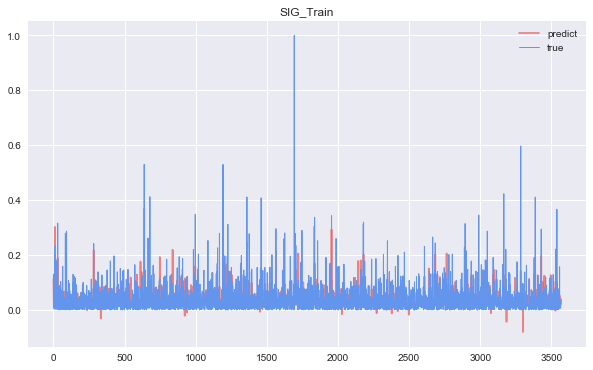

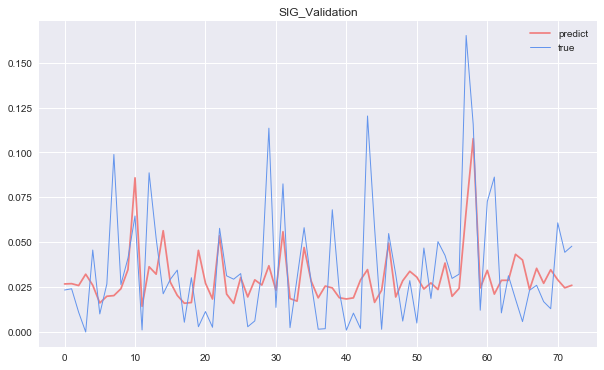

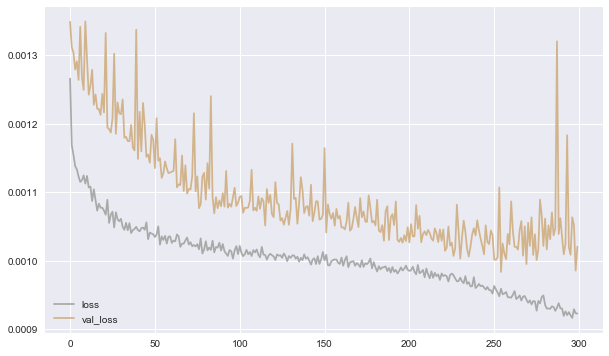

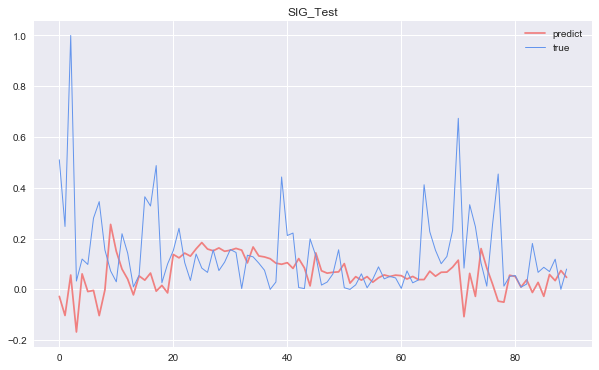

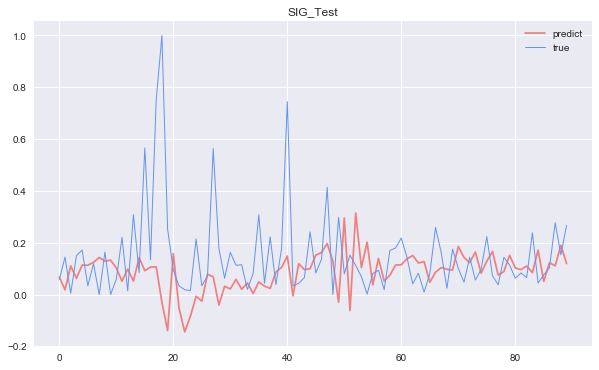

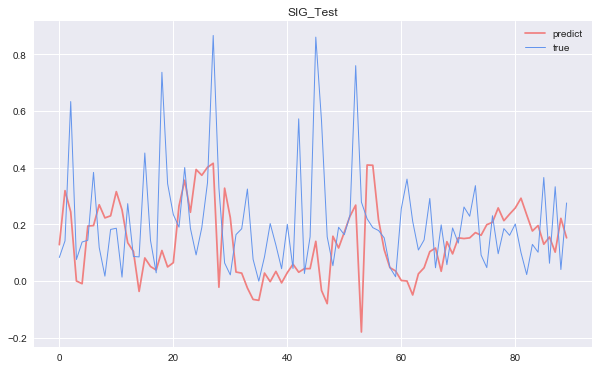

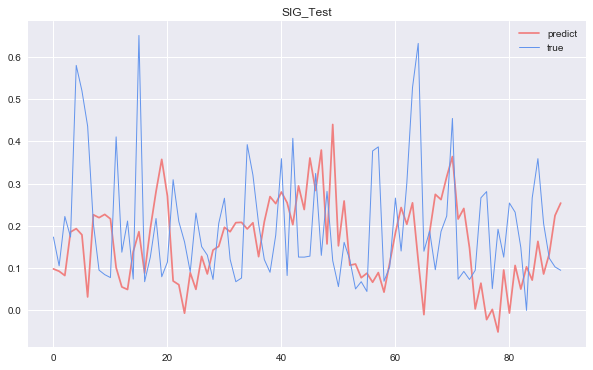

In [23]:
# SIG
hidden_dim = 30
n_epochs = 300
time_steps = 60
batch_size = 260
look_interval = 60
activation = None
loss = 'logcosh'


ticker = 'SIG'
model = new_data_test(ticker, plot = True) 

train (3567, 29, 1) (3567, 1)
insample test (73, 29, 1) (73, 1)


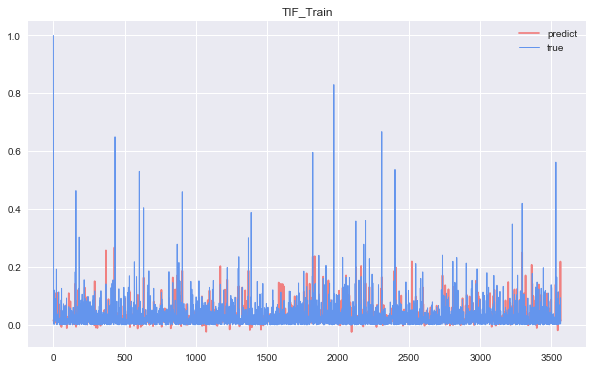

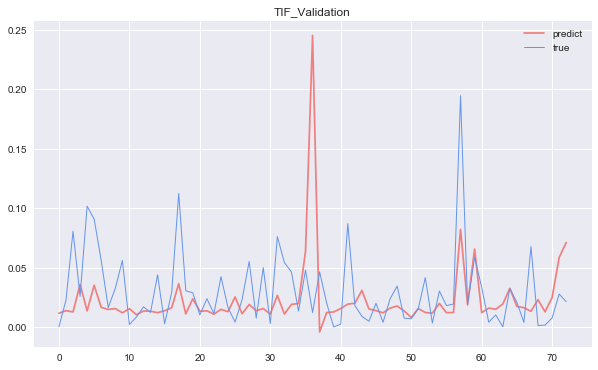

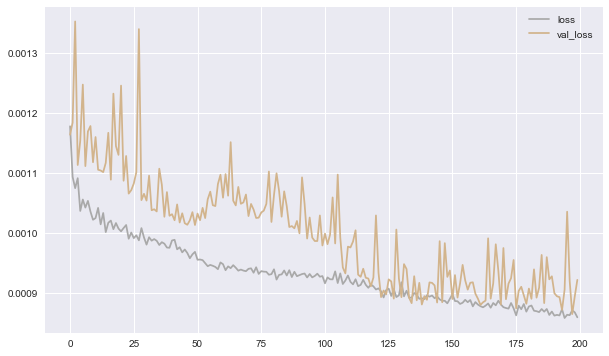

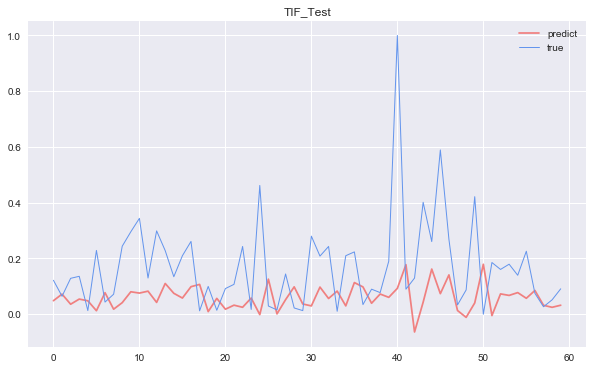

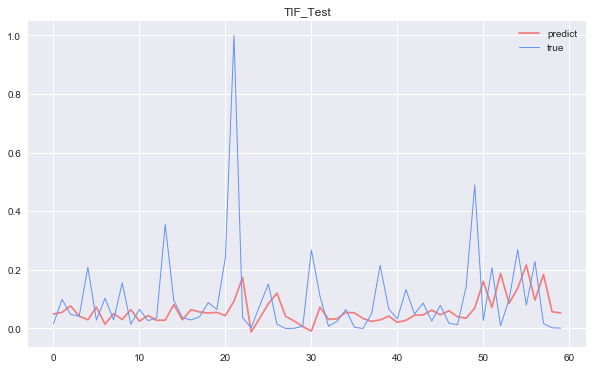

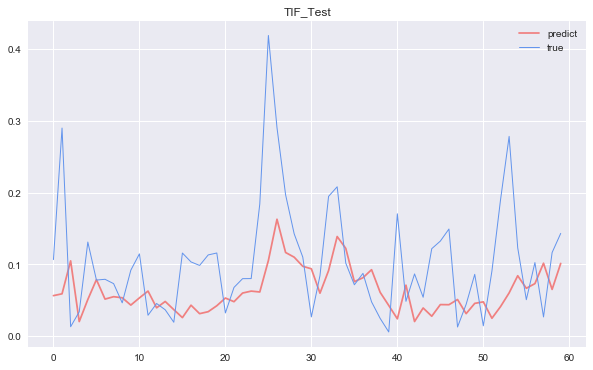

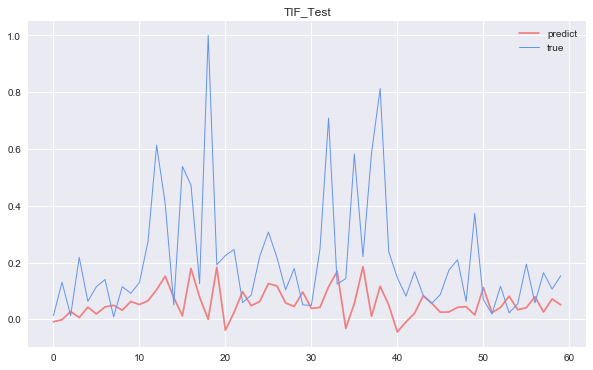

In [22]:
# TIF
hidden_dim = 30
n_epochs = 200
time_steps = 30
batch_size = 260
look_interval = 60
activation = None
loss = 'logcosh'


ticker = 'TIF'
model = new_data_test(ticker, plot = True) 

train (3694, 29, 1) (3694, 1)
insample test (76, 29, 1) (76, 1)


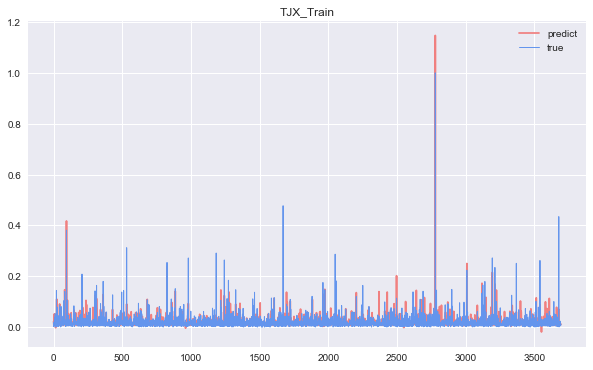

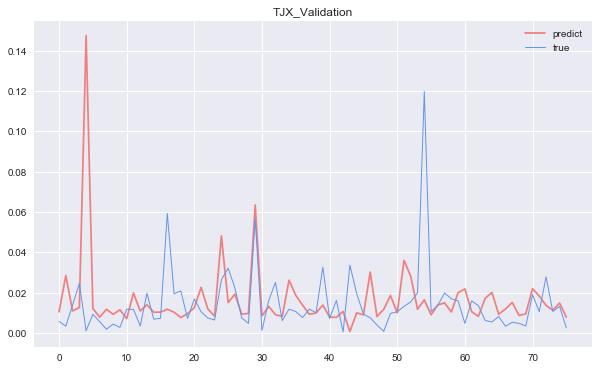

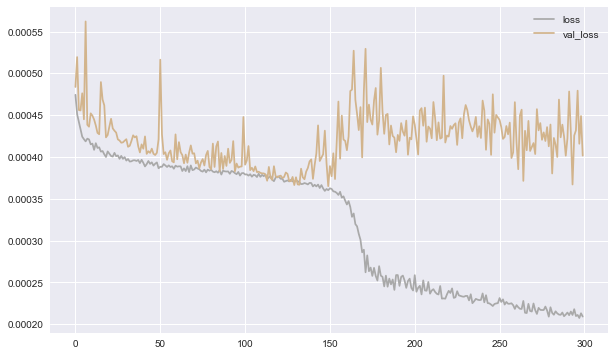

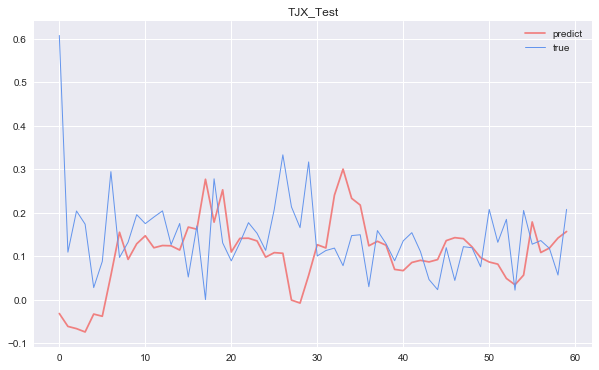

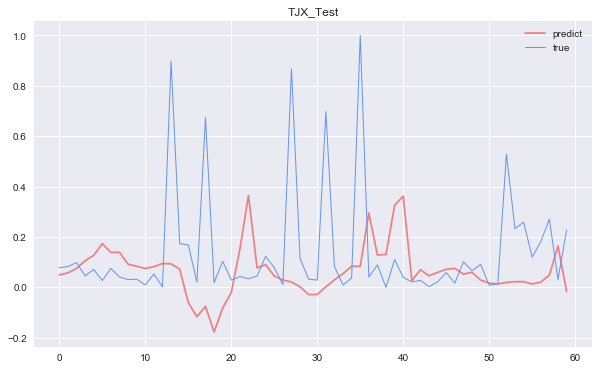

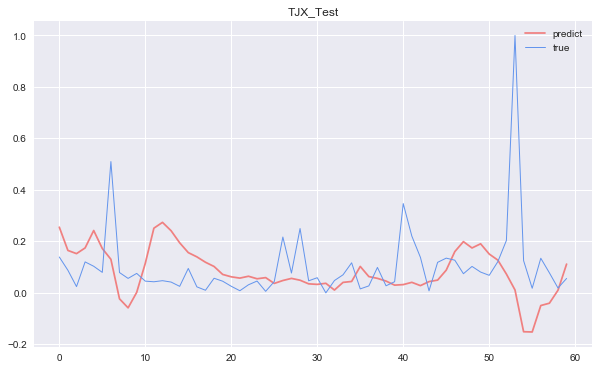

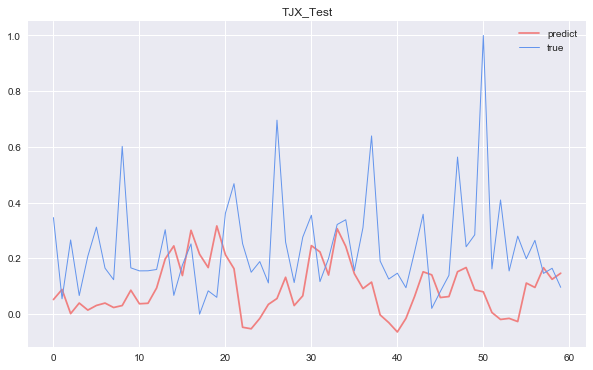

In [21]:
# TJX
hidden_dim = 40
n_epochs = 300
time_steps = 30
batch_size = 130
look_interval = 60
activation = None
loss = 'logcosh'


ticker = 'TJX'
model = new_data_test(ticker, plot = True) 

In [25]:
train_date_list = ['20171010', '20171017', '20171018', '20171030', '20171031', 
                   '20171102', '20171215', '20171218', '20171228', '20180111']
test_date_list = ['20171101', '20171222', '20181217', '20181231'] 
# ticker_list = ['ANF','CTB', 'DRE', 'IVZ', 'KIM', 'MAC', 'PCH', 'SYMC', 'VTR']
ticker_list = ['APC']#,'FTI','HPQ', 'SANM', 'SIG', 'TEX', 'TIF','TJX']

# data_list = ['APC_20171211', 'APC_20171212', 'APC_20171213', 'APC_20171214', 'APC_20171215'] #, 'APC_20171218']


train (3758, 29, 1) (3758, 1)
insample test (77, 29, 1) (77, 1)


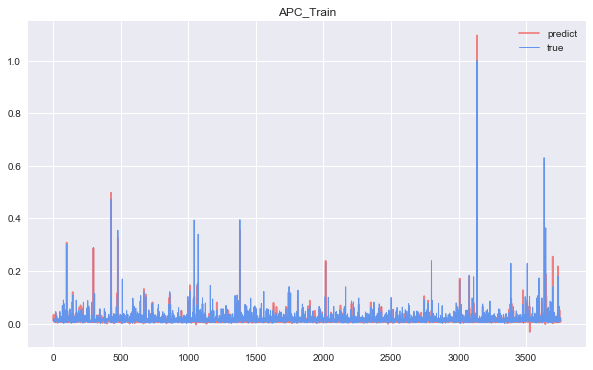

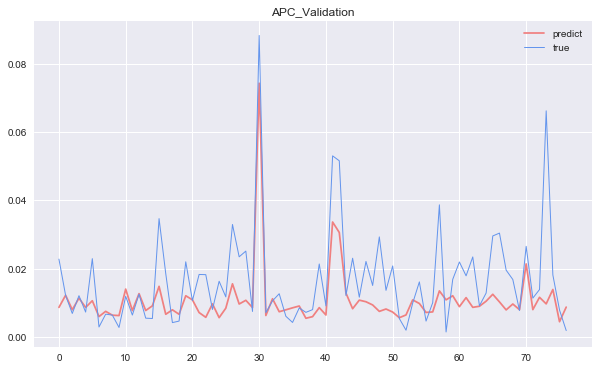

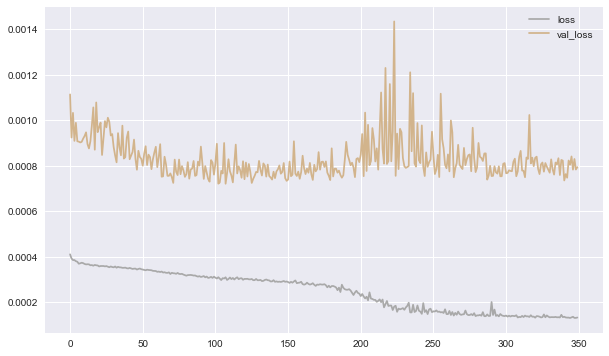

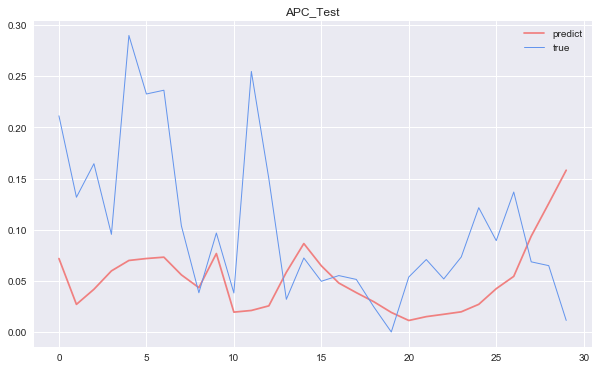

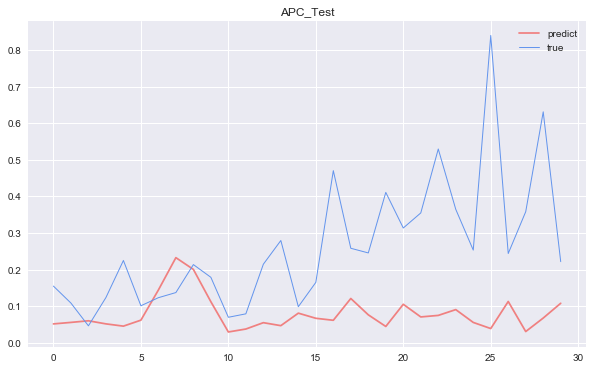

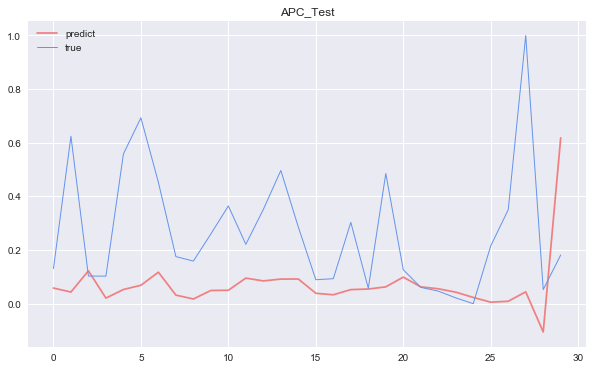

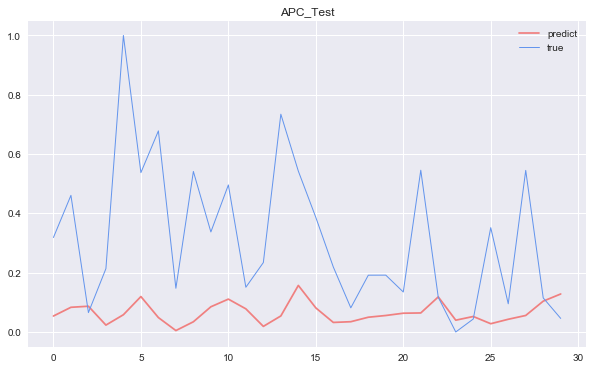

In [20]:
#APC
hidden_dim = 30
n_epochs = 350
batch_size = 65
time_steps = 30
look_interval = 30
activation = None

ticker = 'APC'
model = new_data_test(ticker, plot = True) 

[0.09471222 0.06168295 0.01109506 0.01517598 0.0289154  0.09457264
 0.02498569 0.00731657 0.02349291 0.02819615 0.01593594 0.022921
 0.01729108 0.13448034 0.04093521 0.03264929 0.01944689 0.04026248
 0.03388423 0.0498919  0.03022207 0.04678226 0.01746556 0.01275651
 0.02372168 0.037306   0.0170565  0.03412463 0.01079069 0.01031959]
train (3758, 29, 1) (3758, 1)
insample test (77, 29, 1) (77, 1)


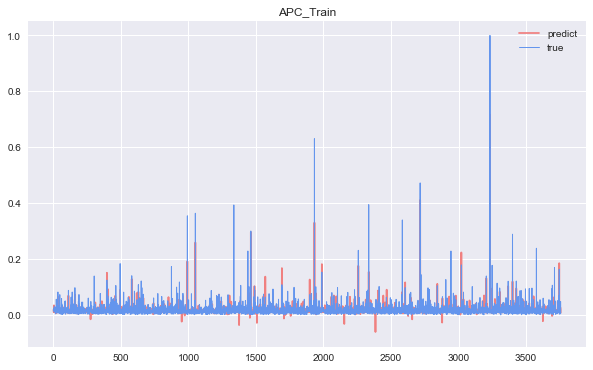

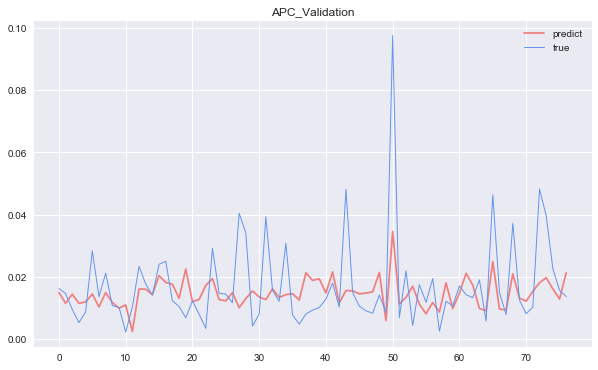

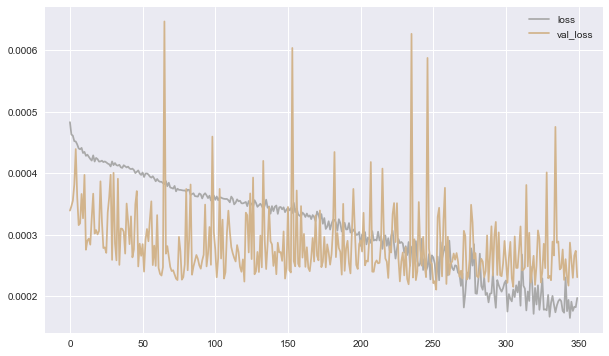

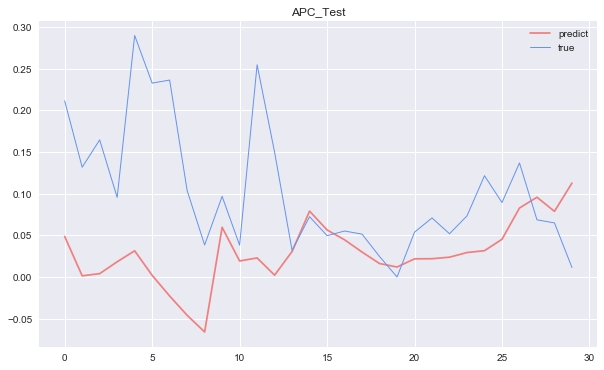

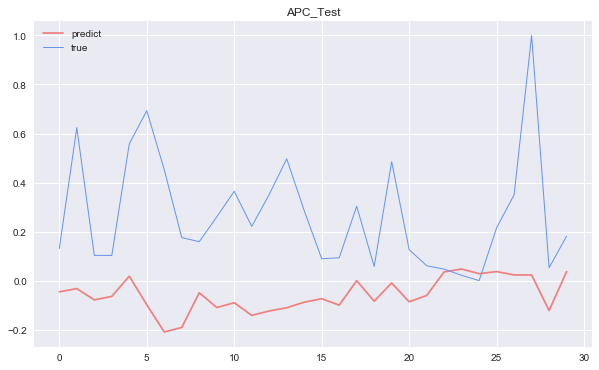

In [75]:
ticker = 'APC'
model = new_data_test(ticker, plot = True) 